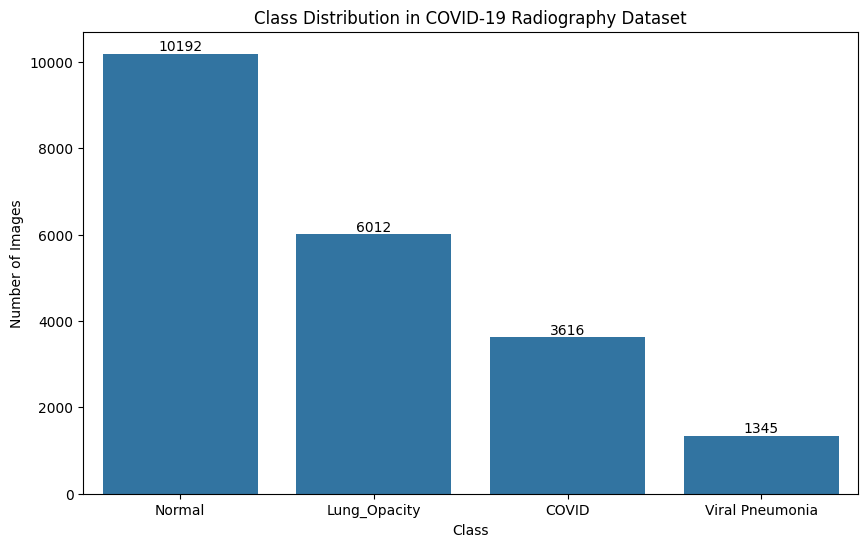

In [1]:
# Load the metadata, and check the class distribution in the dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_base_dir = './covid19-radiography-dataset/'
metadata = pd.read_csv(os.path.join(data_base_dir, 'metadata.csv'))

label_counts = metadata['label'].value_counts()
class_distribution = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Number of Images'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Number of Images', data=class_distribution)
plt.title('Class Distribution in COVID-19 Radiography Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# add counts to each bar
for i in range(class_distribution.shape[0]):
    count = class_distribution.iloc[i, 1]
    plt.text(i, count, count, ha='center', va='bottom')

plt.show()

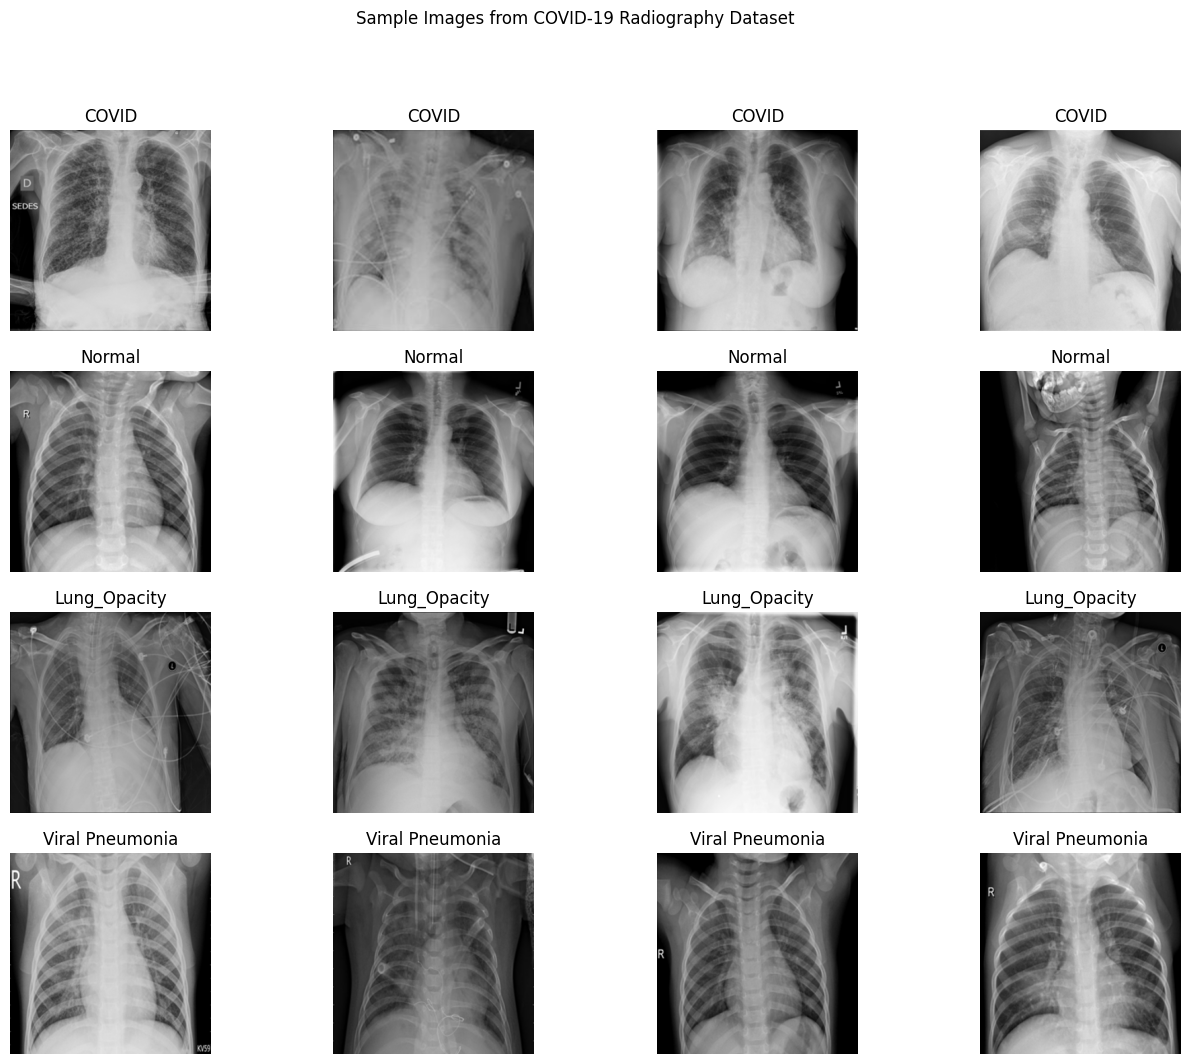

In [6]:
# Display sample images, randomly selected from the dataset

import cv2
import random
import os

radiography_dataset_path = os.path.join(data_base_dir, 'COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset')


def image_filename(image_id: int) -> str:
    """
        Return the filename of the image with the given image_id,
        using the relative base directory path.

        Args:
            image_id: The unique identifier of the image in the metadata

        Returns:
            The relative filename of the image
    """
    return os.path.join(radiography_dataset_path, metadata.loc[image_id, 'label'], metadata.loc[image_id, 'file_name'])


plt.figure(figsize=(16, 12))
# show 4 normal, 4 covid, 4 lung opacity, 4 viral pneumonia images
for i in ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']:
    class_images = metadata[metadata['label'] == i]
    random_indices = random.sample(range(class_images.shape[0]), 4)
    for j, idx in enumerate(random_indices):
        plt.subplot(4, 4, 4 * ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia'].index(i) + j + 1)
        image = cv2.imread(image_filename(class_images.index[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(i)
        plt.axis('off')

plt.suptitle('Sample Images from COVID-19 Radiography Dataset')
plt.show()

In [8]:
# Preprocess the images, ensuring all dimensions are the same (224x224)
# and check the class distribution again.
# Moving forwards we build a new dataframe to store the preprocessed images
# and fit the machine learning models to this new dataset.


def encode_labels(label: str) -> int:
    """
        Return the integer label for the given string label.

        Args:
            label: The string label

        Returns:
            The integer label
    """
    match label.casefold():
        case 'normal':
            return 0
        case 'covid':
            return 1
        case "lung_opacity":
            return 2
        case "viral pneumonia":
            return 3
        case _:
            raise ValueError(f'Invalid label: {label}')


def decode_labels(label: int) -> str:
    """
        Return the string label for the given integer label.

        Args:
            label: The integer label

        Returns:
            The string label
    """
    match label:
        case 0:
            return 'Normal'
        case 1:
            return 'COVID'
        case 2:
            return 'Lung_Opacity'
        case 3:
            return 'Viral Pneumonia'
        case _:
            raise ValueError(f'Invalid label: {label}')


df = pd.DataFrame(columns=['image', 'label'])

for i in metadata.index:
    filename = image_filename(i)
    label = metadata.loc[i, 'label']
    image = cv2.imread(filename)
    image = cv2.resize(image, (224, 224))
    image_flattened = image.flatten().astype(np.float32)

    label = encode_labels(label)
    df.loc[i] = {'image': image, 'label': label}

print(df.head())
print(df.shape)
print(df['label'].value_counts())

                                               image  label
0  [[[145, 145, 145], [18, 18, 18], [0, 0, 0], [0...      1
1  [[[134, 134, 134], [131, 131, 131], [129, 129,...      1
2  [[[49, 49, 49], [4, 4, 4], [0, 0, 0], [0, 0, 0...      1
3  [[[139, 139, 139], [139, 139, 139], [139, 139,...      1
4  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...      1
(21165, 2)
label
0    10192
2     6012
1     3616
3     1345
Name: count, dtype: int64


In [9]:
# split the dataset into training and testing sets

from sklearn.model_selection import train_test_split


labels = df[['image', 'label']]

train, test = train_test_split(labels, test_size=0.2, stratify=labels['label'])
train, val = train_test_split(train, test_size=0.2, stratify=train['label'])

X_train = np.array(train['image'].tolist(), dtype=np.float32)
y_train = train['label'].values

X_train.shape, y_train.shape, test.shape, val.shape

((13545, 224, 224, 3), (13545,), (4233, 2), (3387, 2))

In [10]:
# oversampling the minority classes using SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flattened, y_train)

X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], 224, 224, 3)

X_train, X_val, y_train, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.1, random_state=42)
X_test = np.array(test['image'].tolist(), dtype=np.float32).reshape(-1, 224, 224, 3)
y_test = test['label'].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((23482, 224, 224, 3),
 (23482,),
 (2610, 224, 224, 3),
 (2610,),
 (4233, 224, 224, 3),
 (4233,))

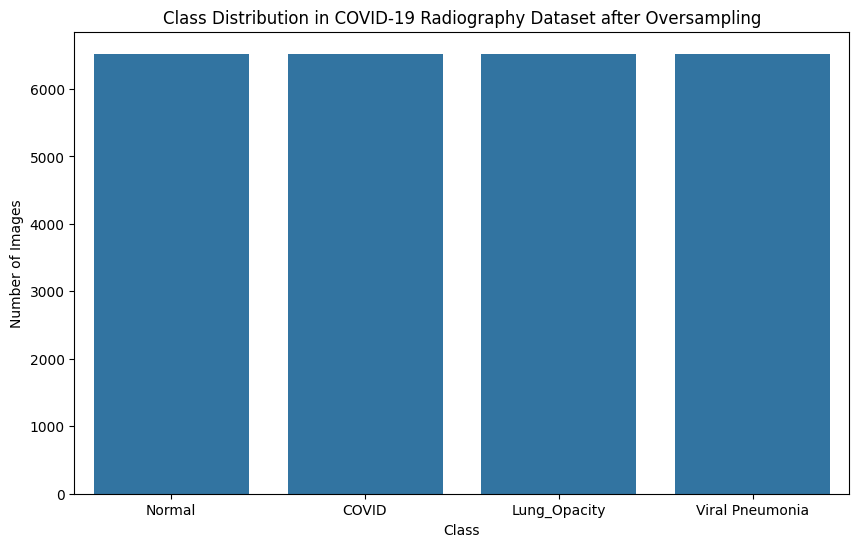

In [16]:
# Show barplot of class balance after oversampling, decoding the labels

plot_pdd = pd.DataFrame({'label': y_train_resampled}).map(decode_labels)

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=plot_pdd)
plt.title('Class Distribution in COVID-19 Radiography Dataset after Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [17]:
import tensorflow as tf

num_classes = len(np.unique(y_train))  # Number of classes

y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# Check shapes
print(y_train_categorical.shape, y_val_categorical.shape, y_test_categorical.shape)

(23482, 4) (2610, 4) (4233, 4)


In [18]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_resnet50 = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)

Epoch 1/50
734/734 ━━━━━━━━━━━━━━━━━━━━ 484s 655ms/step - accuracy: 0.8267 - loss: 0.5648 - val_accuracy: 0.9226 - val_loss: 0.2125
Epoch 2/50
136/734 ━━━━━━━━━━━━━━━━━━━━ 5:56 596ms/step - accuracy: 0.9247 - loss: 0.2016

KeyboardInterrupt: 

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_vgg16 = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)


Epoch 1/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.8646 - loss: 0.7137 - val_accuracy: 0.9533 - val_loss: 0.1102
Epoch 2/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 780s 2s/step - accuracy: 0.9552 - loss: 0.1184 - val_accuracy: 0.9701 - val_loss: 0.0813
Epoch 3/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.9670 - loss: 0.0858 - val_accuracy: 0.9563 - val_loss: 0.1015
Epoch 4/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.9780 - loss: 0.0579 - val_accuracy: 0.9747 - val_loss: 0.0638
Epoch 5/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 777s 2s/step - accuracy: 0.9814 - loss: 0.0466 - val_accuracy: 0.9755 - val_loss: 0.0580
Epoch 6/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.9875 - loss: 0.0359 - val_accuracy: 0.9716 - val_loss: 0.0822
Epoch 7/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.9906 - loss: 0.0276 - val_accuracy: 0.9862 - val_loss: 0.0422
Epoch 8/50
367/367 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.9919 - loss: 0.0235 - val_accu

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_efficientnetb0 = model.fit(
    X_train, y_train_categorical,
    validation_data=(X_val, y_val_categorical),
    epochs=20,
    batch_size=32
)


In [ ]:
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot history for ResNet50
plot_history(history_resnet50, 'ResNet50')

# Plot history for VGG16
plot_history(history_vgg16, 'VGG16')

# Plot history for EfficientNetB0
plot_history(history_efficientnet, 'EfficientNetB0')